In [5]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/nfs/pic.es/user/m/mbilkis/qmon-sindy")
import sys
sys.path.insert(0, os.getcwd())
import numpy as np
from numerics.utilities.misc import *
import torch
from tqdm import tqdm
from scipy.linalg import solve_continuous_are
from numerics.NN.models.FHN import *
from numerics.NN.losses import *
from numerics.NN.misc import *
import copy
import argparse
import matplotlib.pyplot as plt 
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
results_dir = "results/FHN_0_1_2_3"
os.makedirs(results_dir,exist_ok=True)

In [7]:
torch.__version__

'2.1.0+cu121'

In [ ]:
params = list(rrn.para

0


/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)
/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)


3
4


/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)


6
7


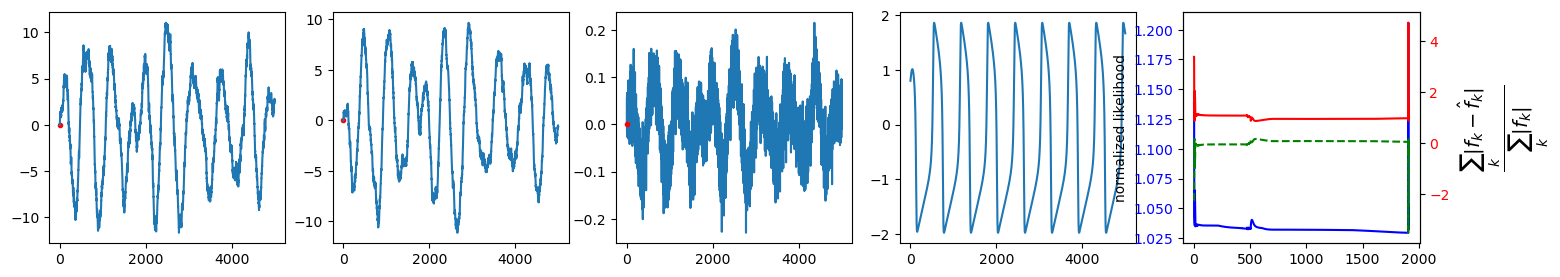

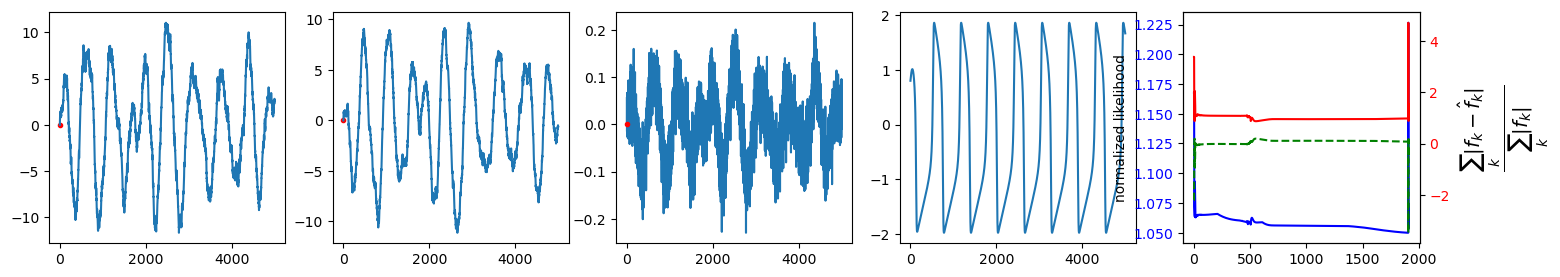

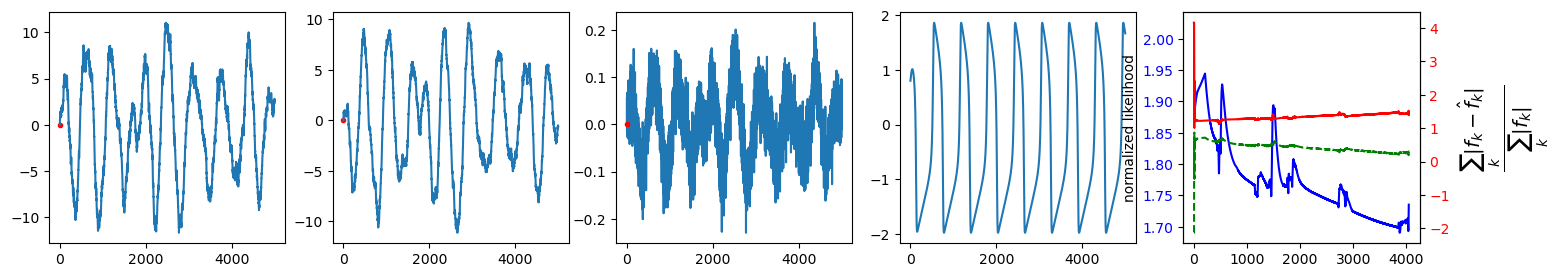

In [9]:
mode="FHN"
alphas = list(np.logspace(-2, 1., 8))

for alpha_ind in range(len(alphas)):

    try:

        itraj = 1
        x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
        dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
        f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
        ####
        params, exp_path = give_params(mode=mode)
        gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
        period = (2*np.pi/omega)
        total_time = period*periods
        dt = period/ppp
        times = np.arange(0,total_time+dt,dt)
        ###

        torch.manual_seed(0)
        np.random.seed(0)


        a,b,I,tau, delay, zoom = np.array(params_force[1]) + np.random.randn((len(params_force[1])))*np.min(np.abs(params_force[1]))
        dev = torch.device("cpu")
        K0 = [I, a/tau]

        K1 = np.array([[1,-1],[1/tau,-b/tau]])
        K2 = K1.copy()
        K3 = np.array([[-1/3,0],[0,0]])

        inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [params_force[0], K0, K1, K2, K3  ]]

        dev = torch.device("cpu")
        rrn = RecurrentNetwork(inputs_cell)

        optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

        dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
        ixs_hat, idys_hat, ifs_hats = rrn(dys)

        history = load_history(what="FHN_0123/regularizers/{}".format(alphas[alpha_ind]), exp_path=exp_path,itraj=itraj)
        best_ind = set_params_to_best(rrn,history)
        xs_hat, dys_hat, fs_hats = rrn(dys)

        best_ind = set_params_to_best(rrn,history)
        xs_hat, dys_hat, fs_hats = rrn(dys)
        loo = history["losses"]
        ll = np.array([[loo[k][0], loo[k][-1]] for k in range(len(loo))])

        plt.figure(figsize=(25,3))
        ax=plt.subplot(171)
        ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(x[:,0])
        ax=plt.subplot(172)
        ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
        ax.plot(x[:,1])
        ax=plt.subplot(173)
        ax.plot(dys[:,0])
        ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

        ax=plt.subplot(174)
        ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(f[:,0])

        ax=plt.subplot(175)
        ax.plot(ll[:,0], color="blue")
        ax.set_ylabel("normalized likelihood")
        ax.tick_params(axis='y', labelcolor="blue")
        ax = ax.twinx()
        ax.plot(ll[:,1], color="red")
        ax.plot(ll[:,0] - ll[:,1], '--', color="green")
        ax.tick_params(axis='y', labelcolor="red")
        ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)
        plt.savefig(results_dir+"{}.pdf".format(alphas[alpha_ind]))
    except Exception:
        print(alpha_ind)

In [ ]:

plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(ixs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(ixs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(idys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(ifs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])
plt.savefig(results_dir+"untrained_{}.png".format(itraj))v

/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)
/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)
/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)
/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

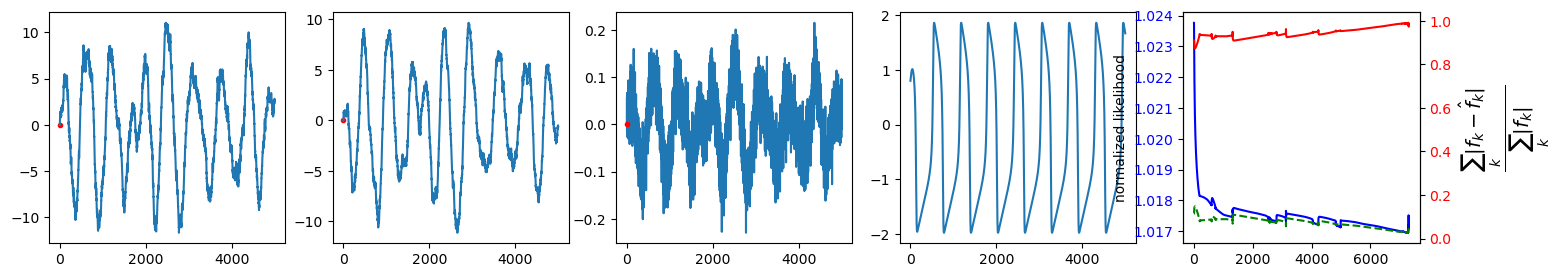

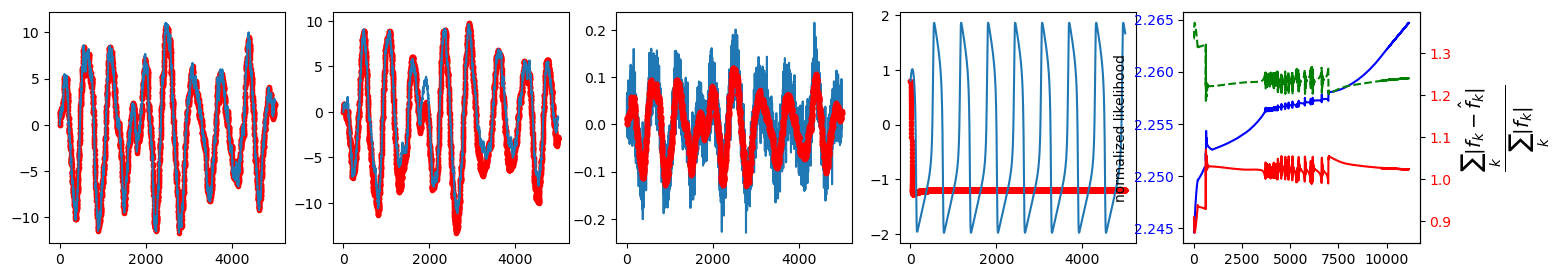

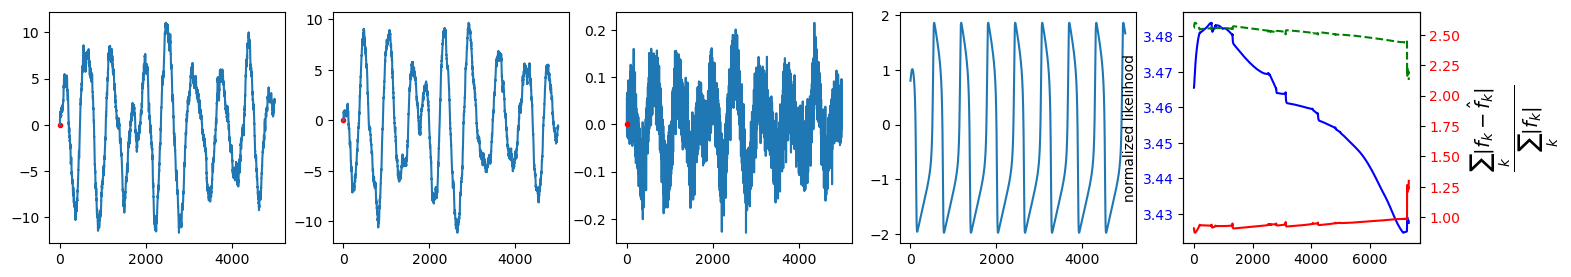

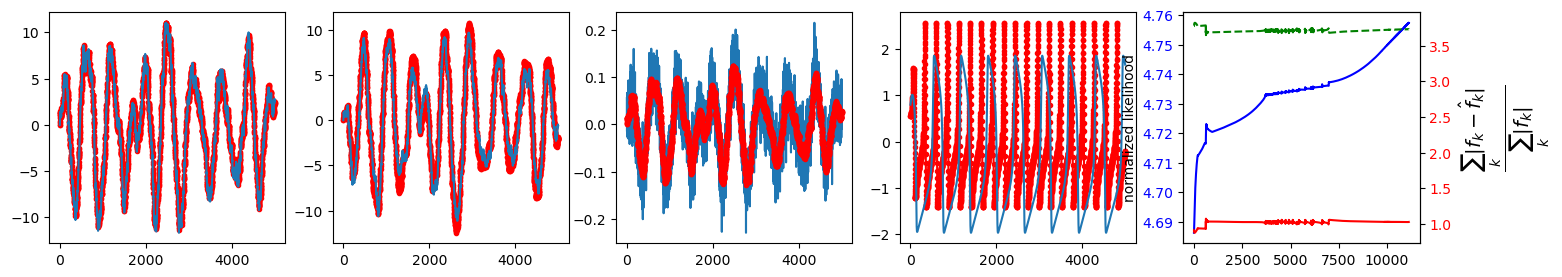

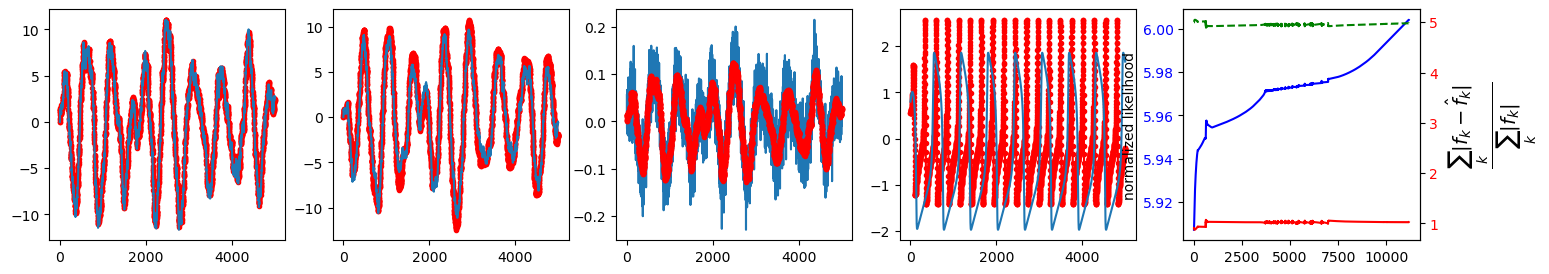

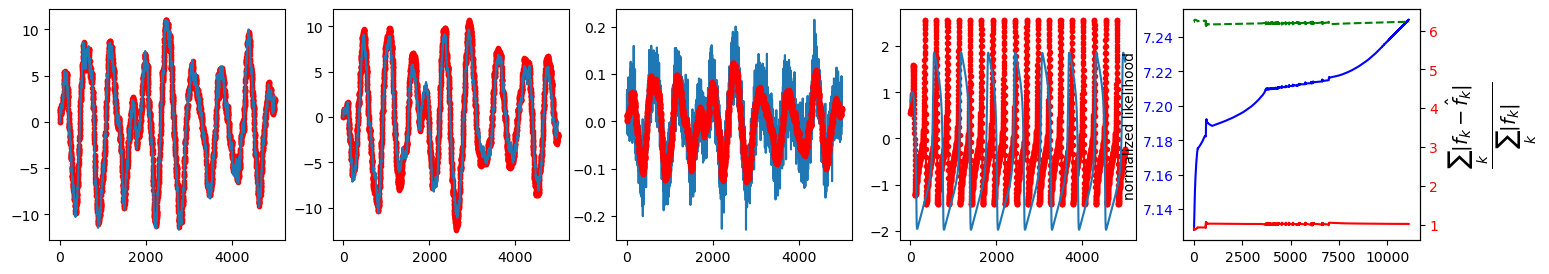

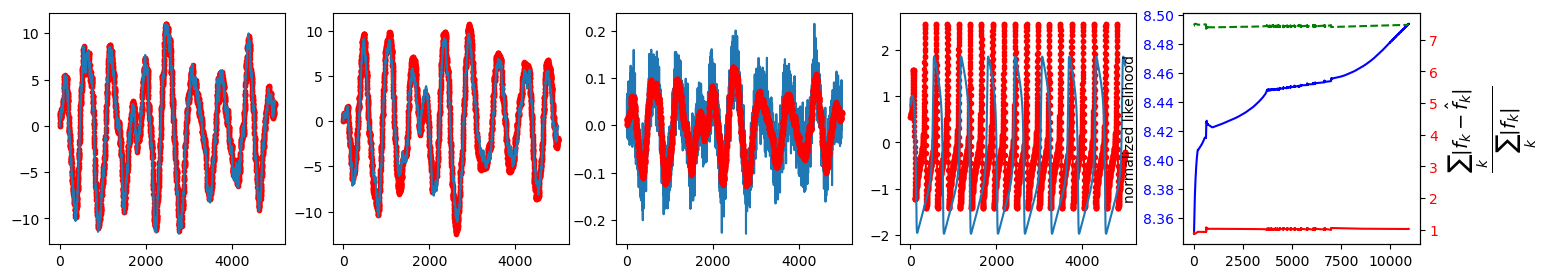

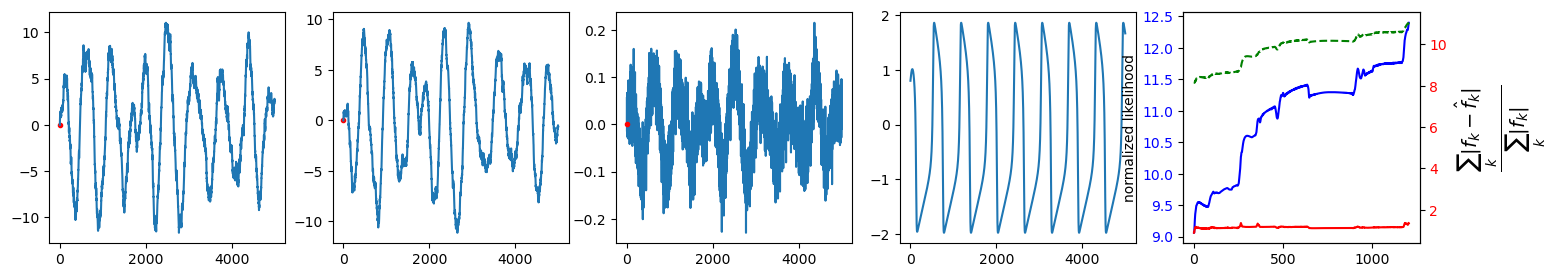

In [6]:
mode="FHN"
alphas = list(np.logspace(-2, 1., 8))

for alpha_ind in range(len(alphas)):


    itraj = 1
    x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
    dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
    f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
    ####
    params, exp_path = give_params(mode=mode)
    gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
    period = (2*np.pi/omega)
    total_time = period*periods
    dt = period/ppp
    times = np.arange(0,total_time+dt,dt)
    ###

    torch.manual_seed(0)
    np.random.seed(0)


    a,b,I,tau, delay, zoom = np.array(params_force[1]) + np.random.randn((len(params_force[1])))*np.min(np.abs(params_force[1]))
    dev = torch.device("cpu")
    K0 = [I, a/tau]

    K1 = np.array([[1,-1],[1/tau,-b/tau]])
    K2 = K1.copy()
    K3 = np.array([[-1/3,0],[0,0]])

    inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [params_force[0], K0, K1, K2, K3  ]]

    dev = torch.device("cpu")
    rrn = RecurrentNetwork(inputs_cell)

    optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

    dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
    ixs_hat, idys_hat, ifs_hats = rrn(dys)

    history = load_history(what="FHN_0123/regularizers/{}".format(alphas[alpha_ind]), exp_path=exp_path,itraj=itraj)
    best_ind = set_params_to_best(rrn,history)
    xs_hat, dys_hat, fs_hats = rrn(dys)

    best_ind = set_params_to_best(rrn,history)
    xs_hat, dys_hat, fs_hats = rrn(dys)
    loo = history["losses"]
    ll = np.array([[loo[k][0], loo[k][-1]] for k in range(len(loo))])

    plt.figure(figsize=(25,3))
    ax=plt.subplot(171)
    ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
    ax.plot(x[:,0])
    ax=plt.subplot(172)
    ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
    ax.plot(x[:,1])
    ax=plt.subplot(173)
    ax.plot(dys[:,0])
    ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

    ax=plt.subplot(174)
    ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
    ax.plot(f[:,0])

    ax=plt.subplot(175)
    ax.plot(ll[:,0], color="blue")
    ax.set_ylabel("normalized likelihood")
    ax.tick_params(axis='y', labelcolor="blue")
    ax = ax.twinx()
    ax.plot(ll[:,1], color="red")
    ax.plot(ll[:,0] - ll[:,1], '--', color="green")
    ax.tick_params(axis='y', labelcolor="red")
    ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)
    plt.savefig(results_dir+"{}.pdf".format(alphas[alpha_ind]))

In [9]:
l0 = torch.sum((dys-dys_hat)**2)/(dt*len(dys))

In [11]:
model = rrn
params = list(model.parameters())[1:]


In [34]:
K0 = np.array([I, a/tau])
K1 = np.array([[1,-1],[1/tau,-b/tau]])
K2 = K1.copy()
K3 = np.array([[-1/3,0],[0,0]])

noise_level = 0.1  
K0 = K0 + np.random.randn(*list(K0.shape))*np.min(K0)*noise_level#np.random.uniform(size=K0.shape)*noise_level
K1 = K1 + np.random.randn(*list(K1.shape))*np.min(K1)*noise_level#np.random.uniform(size=K1.shape)*noise_level
K2 = K2 + np.random.randn(*list(K2.shape))*np.min(K2)*noise_level#np.random.uniform(size=K2.shape)*noise_level
K3 = K3 + np.random.randn(*list(K3.shape))*np.min(K3)*noise_level#np.random.uniform(size=K3.shape)*noise_level
initial_condition = np.array(params_force[0])
initial_condition+=np.random.randn(*list(initial_condition.shape))*np.min(initial_condition)*noise_level#np.random.uniform(size=initial_condition.shape)*noise_level

0.49496725324037755

In [19]:
[max(j) for j in params]

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [16]:
ll = [[k for k in j] for j in params] 

In [ ]:
l0 = torch.sum((dys-dys_hat)**2)/(dt*len(dys))
if alpha>0.0:
    params = list(model.parameters())[1:] #not initial value
    maxim = torch.max(torch.tensor([torch.max(j) for j in params]))
    nparams = np.sum([len(j) for j in params])
    l1 = torch.sum(torch.tensor([torch.sum(torch.abs(k)) for k in params]))/(nparams*maxim)
    return l0 + alpha*l1, torch.stack([l0, alpha*l1]).detach().numpy()


[Parameter containing:
 tensor([nan, nan], requires_grad=True),
 Parameter containing:
 tensor([[nan, nan],
         [nan, nan]], requires_grad=True),
 Parameter containing:
 tensor([[nan, nan],
         [nan, nan]], requires_grad=True),
 Parameter containing:
 tensor([[nan, nan],
         [nan, nan]], requires_grad=True),
 Parameter containing:
 tensor([[nan, nan],
         [nan, nan]], requires_grad=True),
 Parameter containing:
 tensor([[nan, nan],
         [nan, nan]], requires_grad=True),
 Parameter containing:
 tensor([[nan, nan],
         [nan, nan]], requires_grad=True)]

In [7]:
loo = history["losses"]
ll = np.array([[loo[k][0], loo[k][-1]] for k in range(len(loo))])


In [3]:
mode="FHN"
alphas = list(np.linspace(0., 1., 8))

itraj = 1
x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
####
params, exp_path = give_params(mode=mode)
gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)
###

torch.manual_seed(0)
np.random.seed(0)



In [4]:

a,b,I,tau, delay, zoom = np.array(params_force[1]) + np.random.randn((len(params_force[1])))*np.min(np.abs(params_force[1]))
dev = torch.device("cpu")
K0 = [I, a/tau]

K1 = np.array([[1,-1],[1/tau,-b/tau]])
K2 = K1.copy()
K3 = np.array([[-1/3,0],[0,0]])

inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [params_force[0], K0, K1, K2, K3  ]]

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
ixs_hat, idys_hat, ifs_hats = rrn(dys)


In [17]:
history = load_history(what="FHN_0123/regularizers/{}".format(alphas[0]), exp_path=exp_path,itraj=itraj)

In [21]:
k=0
history["losses"][k]

[1.0237663984298706, None, 0.909893429911306]

In [24]:
like = [history["losses"][k][0] for k in range(len(history["losses"]))]

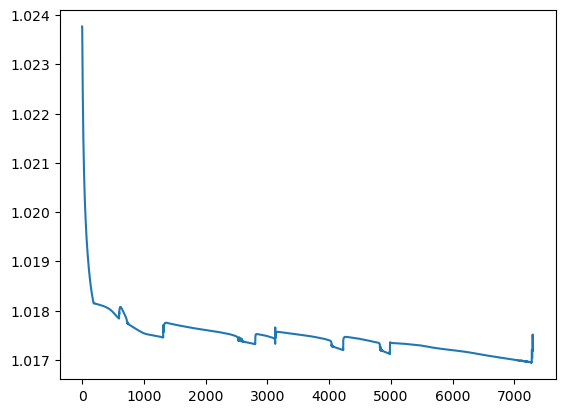

In [26]:
plt.plot(np.array(like))

In [ ]:
best_ind = set_params_to_best(rrn,history)
xs_hat, dys_hat, fs_hats = rrn(dys)


In [12]:

best_ind = set_params_to_best(rrn,history)
xs_hat, dys_hat, fs_hats = rrn(dys)
loo = history["losses"]
ll = np.array([[loo[k][0], loo[k][-1]] for k in range(len(loo))])


KeyboardInterrupt



KeyboardInterrupt: 

In [8]:
results_dir = "results/FHN_0123/"
os.makedirs(results_dir,exist_ok=True)

/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)
/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)
/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)
/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

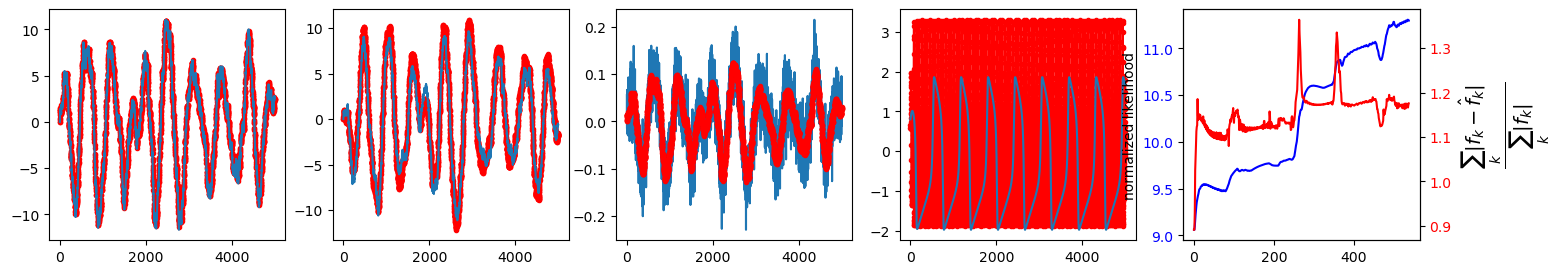

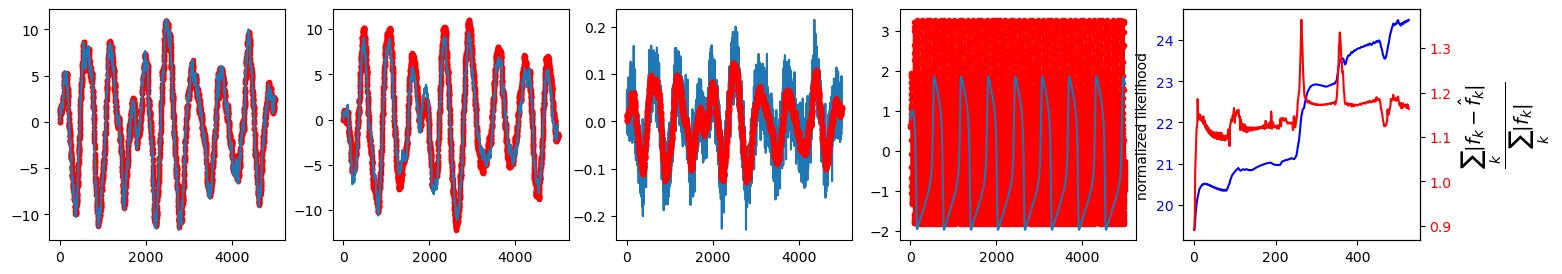

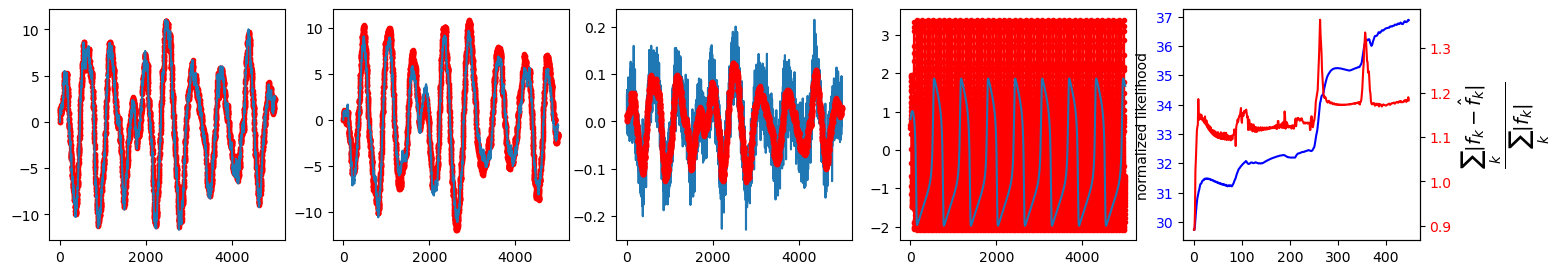

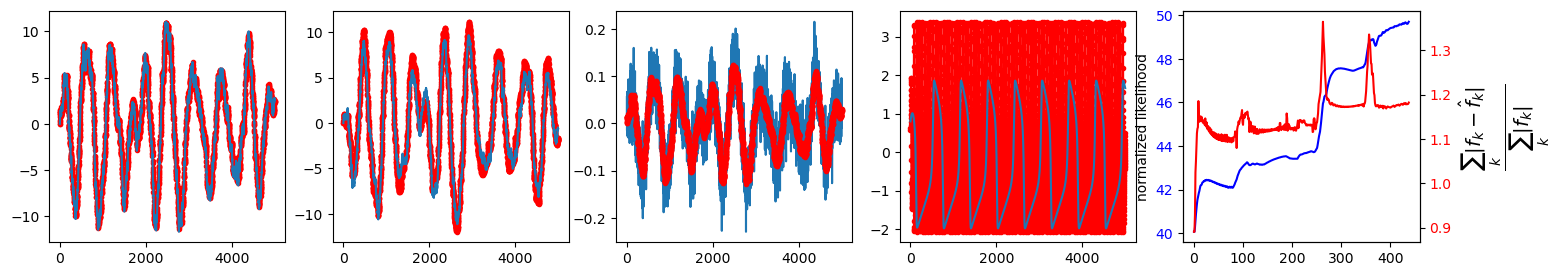

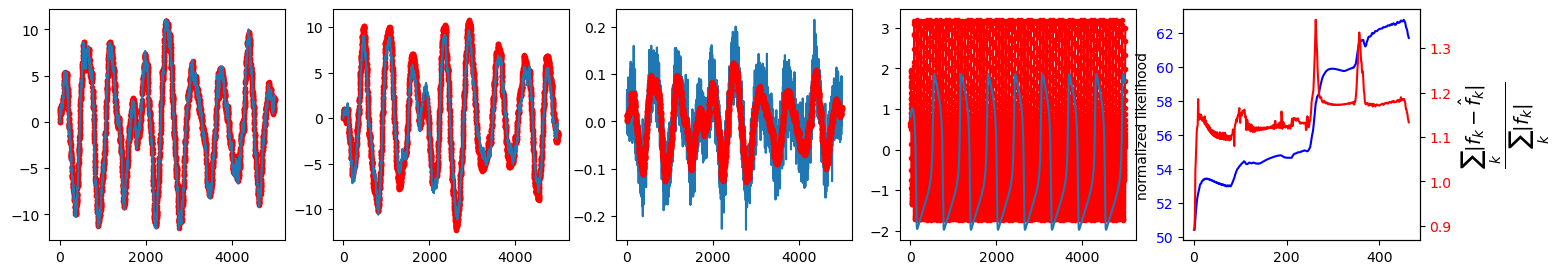

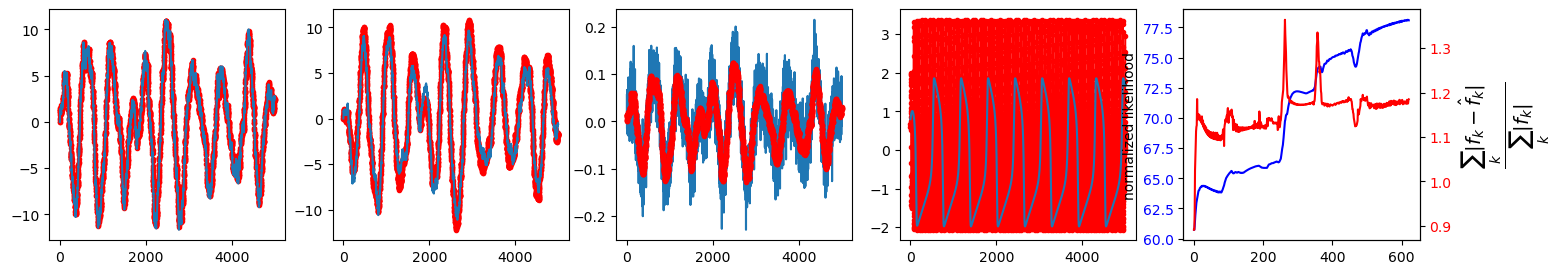

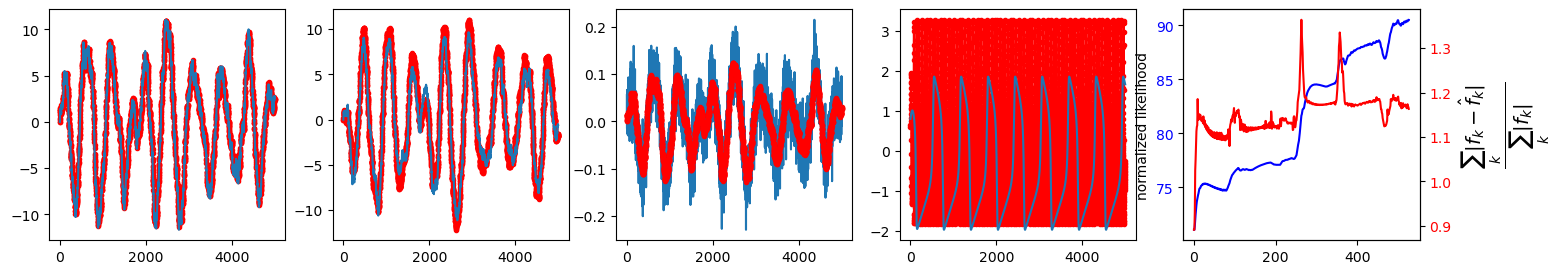

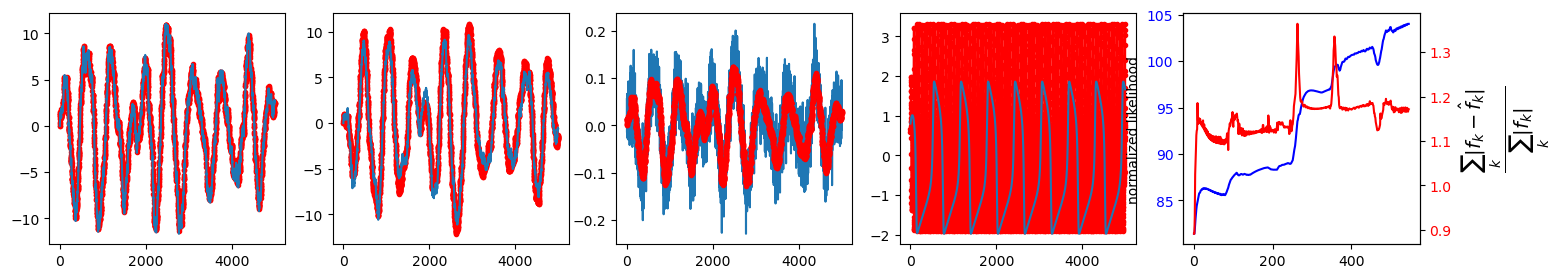

In [17]:
mode="FHN"
alphas = list(np.linspace(1., 10., 8))

for alpha_ind in range(len(alphas)):

    itraj = 1
    x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
    dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
    f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
    ####
    params, exp_path = give_params(mode=mode)
    gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
    period = (2*np.pi/omega)
    total_time = period*periods
    dt = period/ppp
    times = np.arange(0,total_time+dt,dt)
    ###

    torch.manual_seed(0)
    np.random.seed(0)


    a,b,I,tau, delay, zoom = np.array(params_force[1]) + np.random.randn((len(params_force[1])))*np.min(np.abs(params_force[1]))
    dev = torch.device("cpu")
    K0 = [I, a/tau]

    K1 = np.array([[1,-1],[1/tau,-b/tau]])
    K2 = K1.copy()
    K3 = np.array([[-1/3,0],[0,0]])

    inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [params_force[0], K0, K1, K2, K3  ]]

    dev = torch.device("cpu")
    rrn = RecurrentNetwork(inputs_cell)

    optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

    dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
    ixs_hat, idys_hat, ifs_hats = rrn(dys)

    history = load_history(what="FHN_0123/regularizers/{}".format(alphas[alpha_ind]), exp_path=exp_path,itraj=itraj)
    best_ind = set_params_to_best(rrn,history)
    xs_hat, dys_hat, fs_hats = rrn(dys)

    best_ind = set_params_to_best(rrn,history)
    xs_hat, dys_hat, fs_hats = rrn(dys)
    loo = history["losses"]
    ll = np.array([[loo[k][0], loo[k][-1]] for k in range(len(loo))])

    plt.figure(figsize=(25,3))
    ax=plt.subplot(171)
    ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
    ax.plot(x[:,0])
    ax=plt.subplot(172)
    ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
    ax.plot(x[:,1])
    ax=plt.subplot(173)
    ax.plot(dys[:,0])
    ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

    ax=plt.subplot(174)
    ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
    ax.plot(f[:,0])

    ax=plt.subplot(175)
    ax.plot(ll[:,0], color="blue")
    ax.set_ylabel("normalized likelihood")
    ax.tick_params(axis='y', labelcolor="blue")
    ax = ax.twinx()
    ax.plot(ll[:,-1], color="red")
    ax.tick_params(axis='y', labelcolor="red")
    ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)
    plt.savefig(results_dir+"{}.pdf".format(alphas[alpha_ind]))

In [11]:
mode="FHN"
alphas = list(np.linspace(0., 1., 8))
itraj = 1
x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
####
params, exp_path = give_params(mode=mode)
gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)
###

torch.manual_seed(0)
np.random.seed(0)


a,b,I,tau, delay, zoom = np.array(params_force[1]) + np.random.randn((len(params_force[1])))*np.min(np.abs(params_force[1]))
dev = torch.device("cpu")
K0 = [I, a/tau]

K1 = np.array([[1,-1],[1/tau,-b/tau]])
K2 = K1.copy()
K3 = np.array([[-1/3,0],[0,0]])

inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [params_force[0], K0, K1, K2, K3  ]]

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
ixs_hat, idys_hat, ifs_hats = rrn(dys)

history = load_history(what="FHN_0123/regularizers/{}".format(alphas[0]), exp_path=exp_path,itraj=itraj)
best_ind = set_params_to_best(rrn,history)
xs_hat, dys_hat, fs_hats = rrn(dys)
best_ind = set_params_to_best(rrn,history)
xs_hat, dys_hat, fs_hats = rrn(dys)
loo = history["losses"]
ll = np.array([[loo[k][0], loo[k][-1]] for k in range(len(loo))])

plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])

ax=plt.subplot(175)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)



KeyboardInterrupt



In [98]:
### PARAMETERS IN THE SIMULATION
[params_force[0], K0, K1, K3]

[[0.8, 1.0],
 [0.9893689920528697, 0.11615082966737726],
 array([[ 1.        , -1.        ],
        [ 0.07341903, -0.0734248 ]]),
 array([[-0.33333333,  0.        ],
        [ 0.        ,  0.        ]])]

In [96]:
## INITIAL SEED MAXIMUM LIKELIHOOD
history["params"][0]

[tensor([0.9365, 1.1401]),
 tensor([0.9984, 0.1045]),
 tensor([[ 1.0007, -0.9887],
         [ 0.0810, -0.0856]]),
 tensor([[-0.3312,  0.0009],
         [ 0.0030,  0.0053]])]

In [99]:
K1.copy()

array([[ 1.        , -1.        ],
       [ 0.07341903, -0.0734248 ]])

In [28]:
## BEST RESULTS MAXIMUM LIKELIHOOD
history["params"][best_ind]

[tensor([0.8353, 1.0331]),
 tensor([0.9973, 0.1081]),
 tensor([[ 0.9942, -0.9953],
         [ 0.0804, -0.0817]]),
 tensor([[-3.3775e-01, -2.6911e-03],
         [ 5.7242e-03, -3.1335e-04]])]

In [76]:
params_force

[[0.8, 1.0], [0.7, 0.8, 0.5, 12.5, 50.0, 10.0], 'FHN']

In [79]:
K1.flatten()

array([ 1.        , -1.        ,  0.07341903, -0.0734248 ])

In [81]:
K0 = [I, a/tau]

K1 = np.array([[1,-1],[1/tau,-b/tau]])

K3 = np.array([[-1/3,0],[0,0]])

tp = []
for k in range(2):
    tp.append(params_force[0][k])
for k in K0:
    tp.append(k)
for k in K1.flatten():
    tp.append(k)
for k in K3.flatten():
    tp.append(k)

In [94]:
params_ev = history["params"]
ev=[]
labels = []
f0_x =[params_ev[k][0][0] for k in range(len(params_ev))]
f0_y =[params_ev[k][0][1] for k in range(len(params_ev))]

pred_K0_0 =[params_ev[k][1][0] for k in range(len(params_ev))]
pred_K0_1 =[params_ev[k][1][1] for k in range(len(params_ev))]

pred_K1_00 =[params_ev[k][2][0,0] for k in range(len(params_ev))]
pred_K1_01 =[params_ev[k][2][0,1] for k in range(len(params_ev))]
pred_K1_10 =[params_ev[k][2][1,0] for k in range(len(params_ev))]
pred_K1_11 =[params_ev[k][2][1,1] for k in range(len(params_ev))]

pred_K3_00 =[params_ev[k][3][0,0] for k in range(len(params_ev))]
pred_K3_01 =[params_ev[k][3][0,1] for k in range(len(params_ev))]
pred_K3_10 =[params_ev[k][3][1,0] for k in range(len(params_ev))]
pred_K3_11 =[params_ev[k][3][1,1] for k in range(len(params_ev))]

ev.append(f0_x)
ev.append(f0_y)
ev.append(pred_K0_0)
ev.append(pred_K0_1)

ev.append(pred_K1_00)
ev.append(pred_K1_01)
ev.append(pred_K1_10)
ev.append(pred_K1_11)

ev.append(pred_K3_00)
ev.append(pred_K3_01)
ev.append(pred_K3_10)
ev.append(pred_K3_11)

labels.append("f0_0")
labels.append("f0_1")

labels.append("K0_0")
labels.append("K0_1")

labels.append("K1_00")
labels.append("K1_01")
labels.append("K1_10")
labels.append("K1_11")

labels.append("K3_00")
labels.append("K3_01")
labels.append("K3_10")
labels.append("K3_11")


In [89]:
save_dir="results/FHN/0_1_3/"
os.makedirs(save_dir, exist_ok=True)

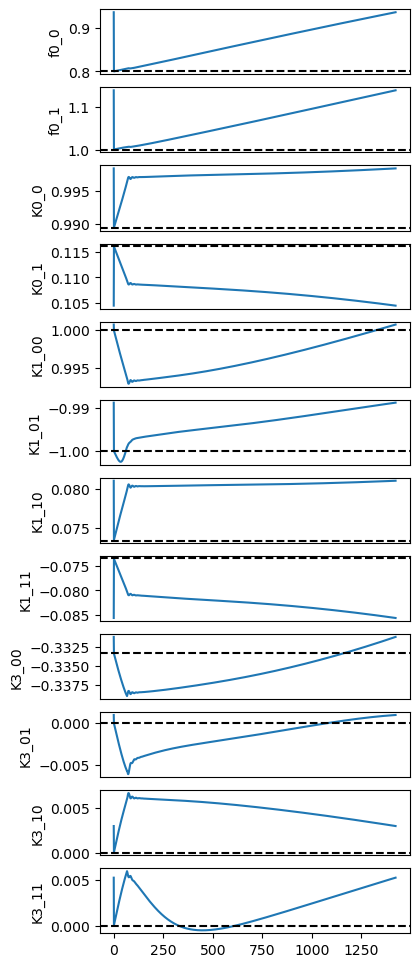

In [95]:
Nparams=12
fig=plt.figure(figsize=(4,(int(Nparams))))
fig.tight_layout()
for k in range(Nparams):
    ax=plt.subplot2grid((Nparams,1), (k,0))
    ax.plot(ev[k])
    ax.axhline(tp[k],linestyle="--", color="black")    
    if k!=Nparams-1:
        ax.set_xticks([])
    ax.set_ylabel(labels[k],size=10)
plt.savefig(save_dir+"evolution_params.png")

In [33]:
K3

array([[-0.33333333,  0.        ],
       [ 0.        ,  0.        ]])

In [34]:
itraj = 1
x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
####
params, exp_path = give_params(mode=mode)
gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)
###

torch.manual_seed(0)
np.random.seed(0)


a,b,I,tau, delay, zoom = np.array(params_force[1]) + np.random.randn((len(params_force[1])))*np.min(np.abs(params_force[1]))
dev = torch.device("cpu")
K0 = [I, a/tau]

K1 = np.array([[1,-1],[1/tau,-b/tau]])

K3 = np.array([[-1/3,0],[0,0]])

inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [params_force[0], K0, K1, K3  ]]
dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
ixs_hat, idys_hat, ifs_hats = rrn(dys)

Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

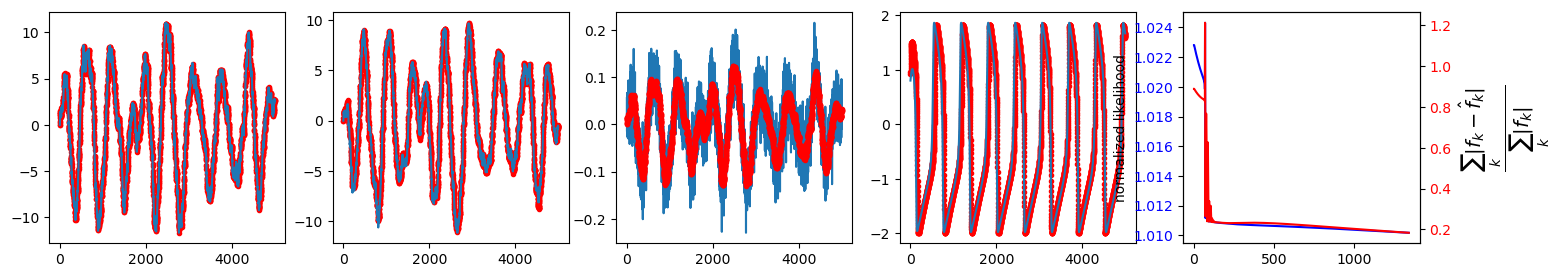

In [40]:
history = load_history(what="FHN/regularizers/{}".format(alphas[0]), exp_path=exp_path,itraj=itraj)
best_ind = set_params_to_best(rrn,history)
xs_hat, dys_hat, fs_hats = rrn(dys)
loo = history["losses"]
ll = np.array([[loo[k][0], loo[k][-1]] for k in range(len(loo))])

plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])

ax=plt.subplot(175)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)


0.0 0
err  0
0.05263157894736842 1


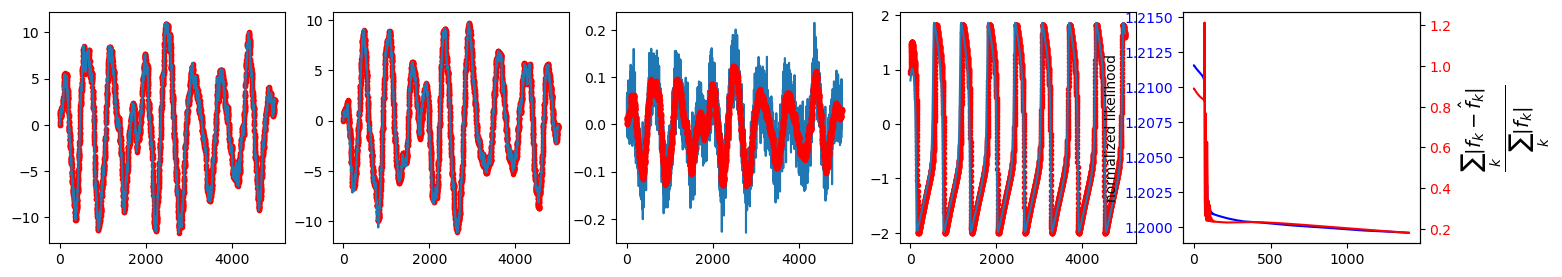

0.10526315789473684 2


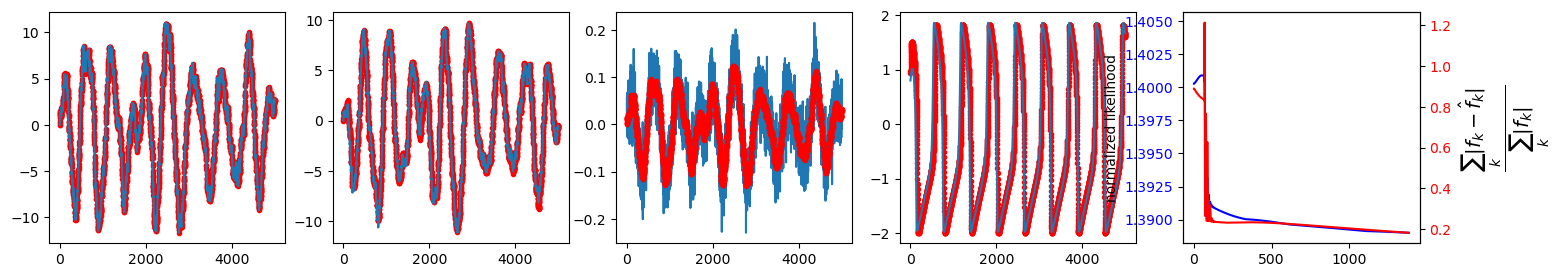

0.15789473684210525 3
err  3
0.21052631578947367 4


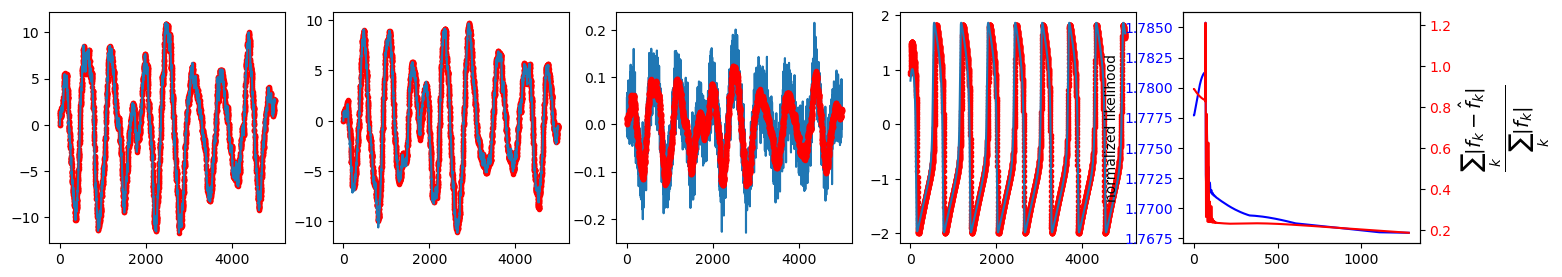

0.2631578947368421 5


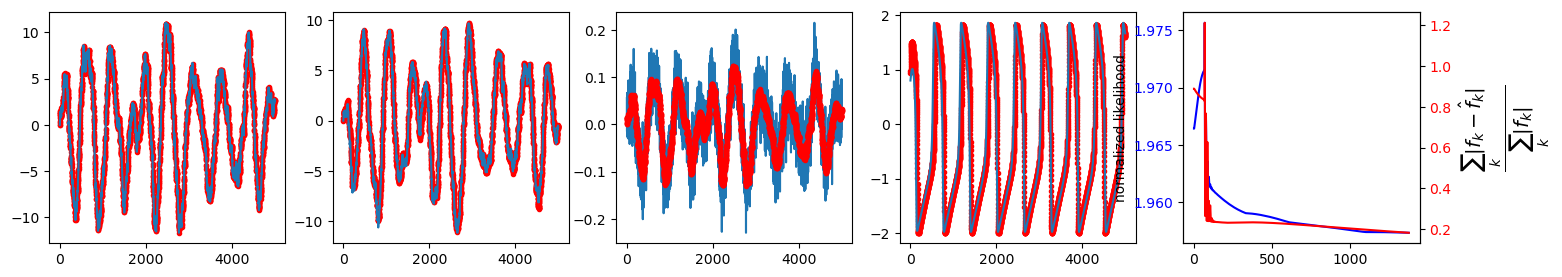

0.3157894736842105 6


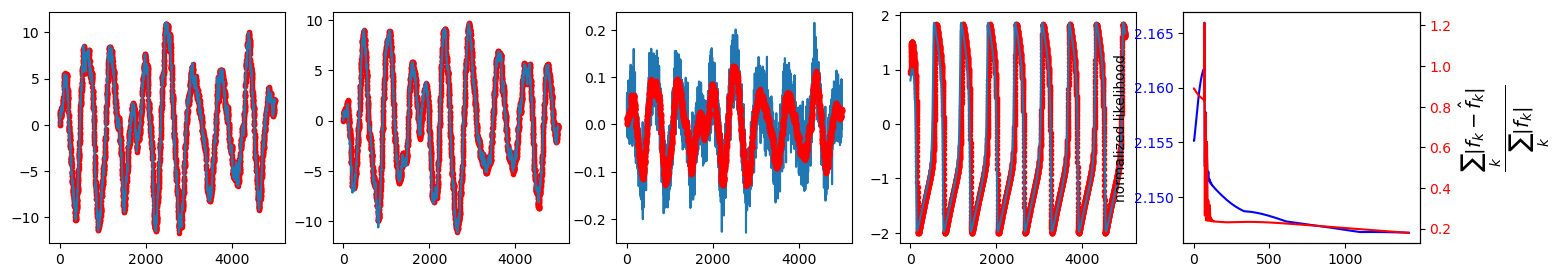

0.3684210526315789 7


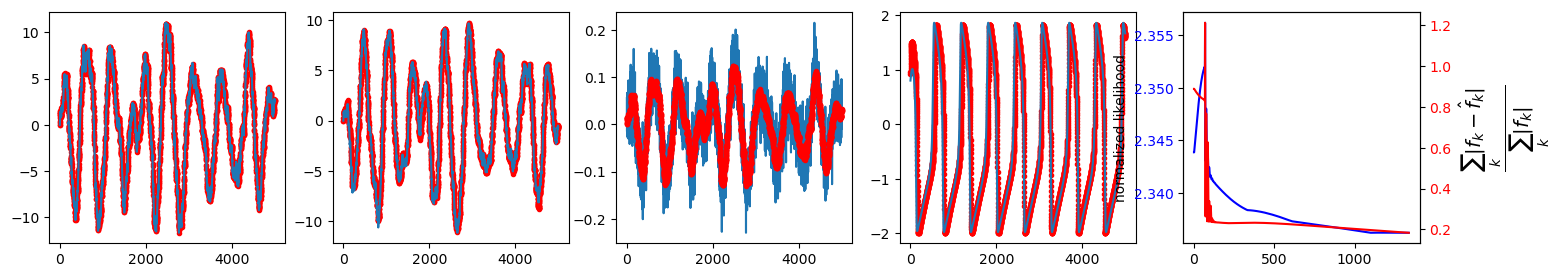

0.42105263157894735 8


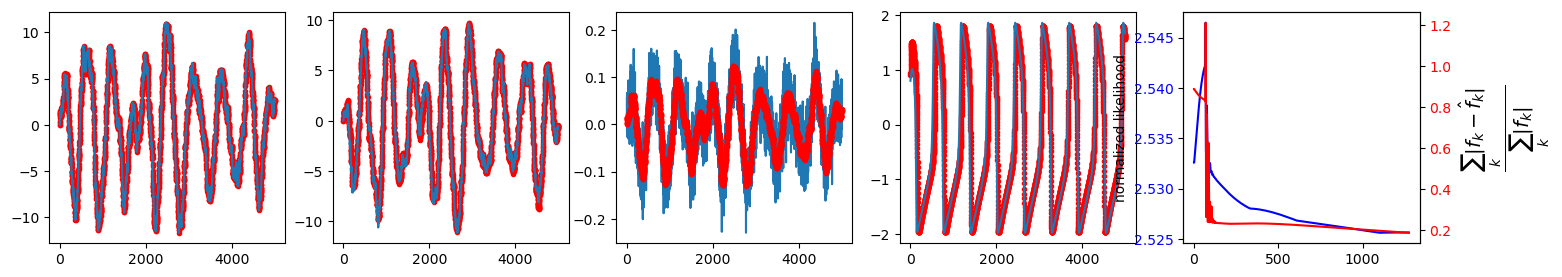

0.47368421052631576 9


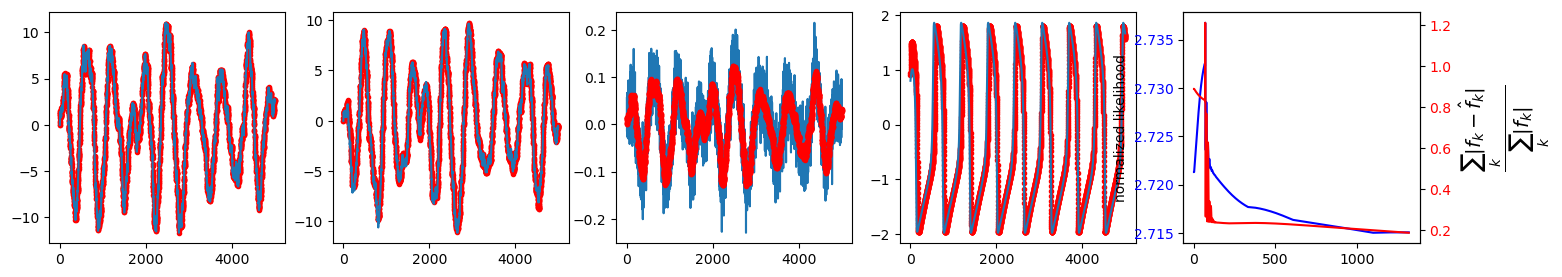

0.5263157894736842 10


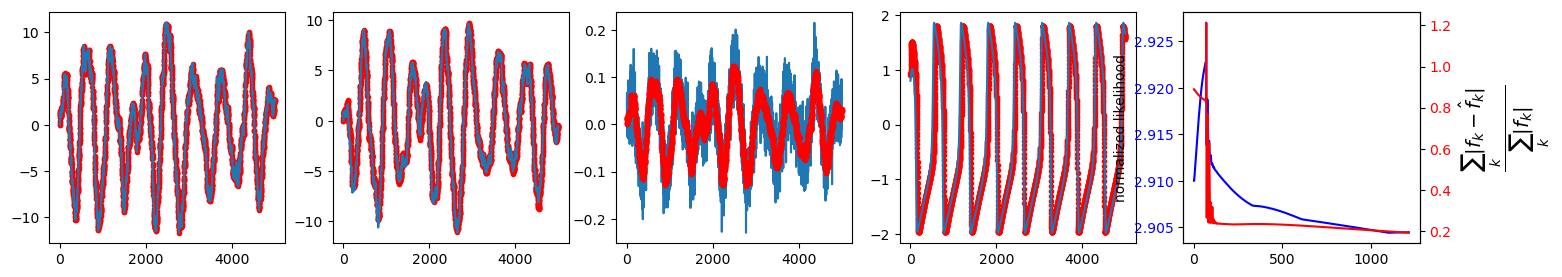

0.5789473684210527 11


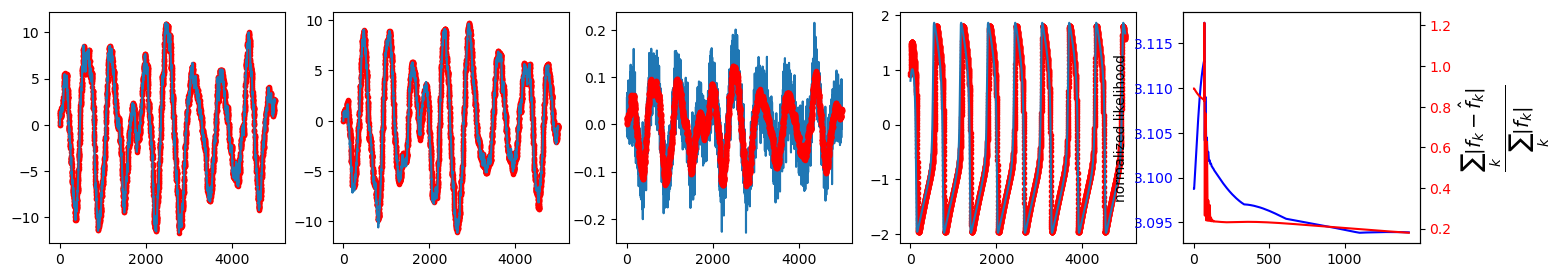

0.631578947368421 12
err  12
0.6842105263157894 13


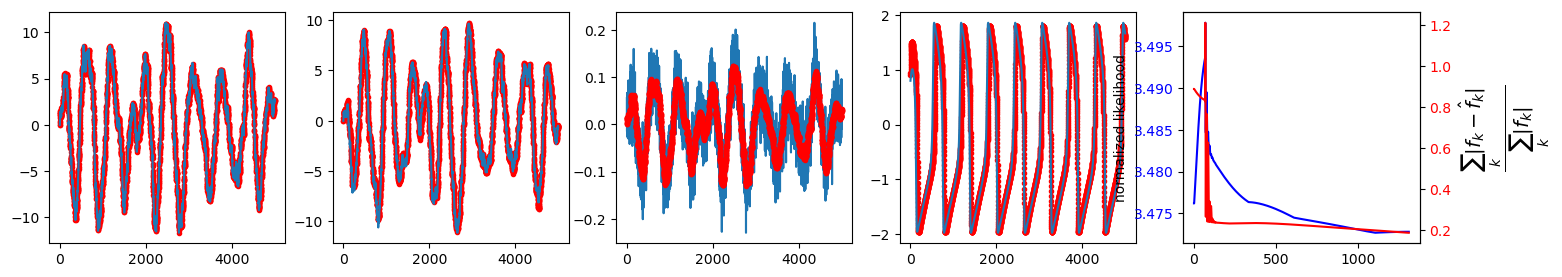

0.7368421052631579 14
err  14
0.7894736842105263 15


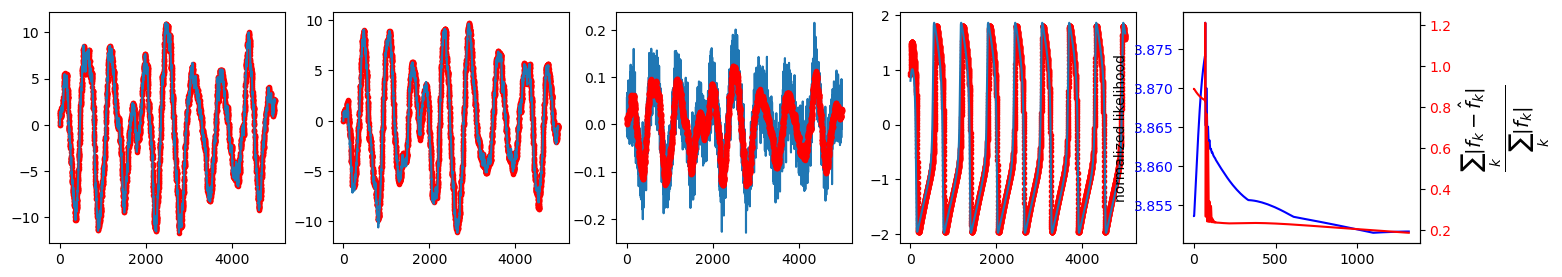

0.8421052631578947 16


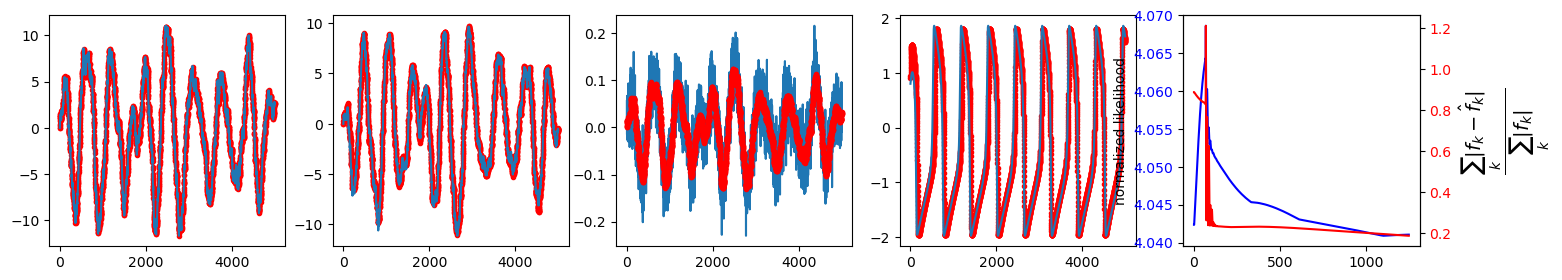

0.894736842105263 17


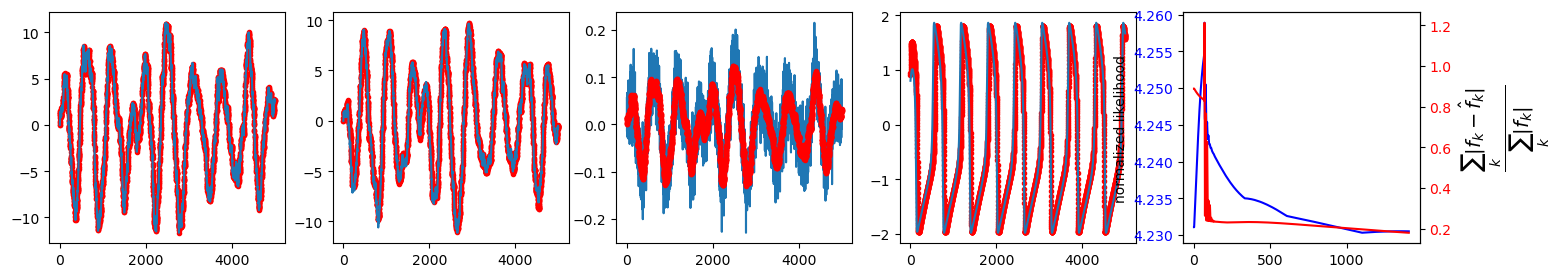

0.9473684210526315 18
err  18
1.0 19


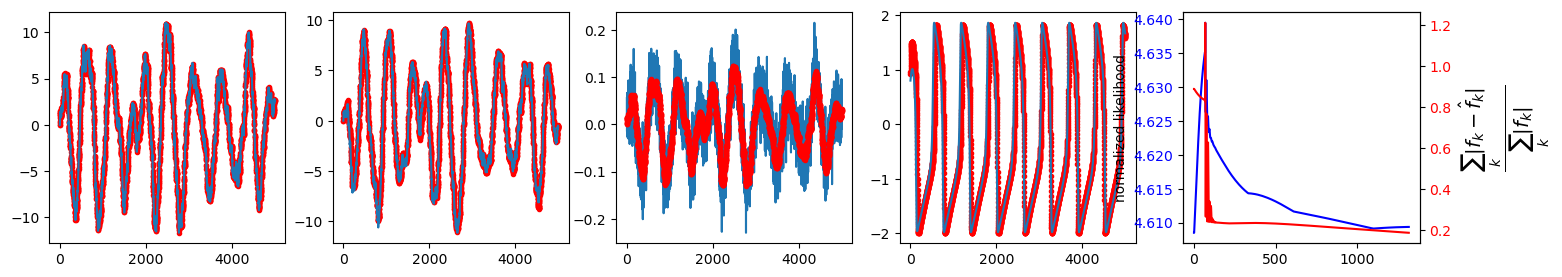

In [44]:
for k in range(20):
    try:
        alpha = alphas[k]
        print(alpha, k)
        history = load_history(what="FHN/regularizers/{}".format(alpha), exp_path=exp_path,itraj=itraj)
        best_ind = set_params_to_best(rrn,history)
        xs_hat, dys_hat, fs_hats = rrn(dys)
        loo = history["losses"]
        ll = np.array([[loo[k][0], loo[k][-1]] for k in range(len(loo))])

        plt.figure(figsize=(25,3))
        ax=plt.subplot(171)
        ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(x[:,0])
        ax=plt.subplot(172)
        ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
        ax.plot(x[:,1])
        ax=plt.subplot(173)
        ax.plot(dys[:,0])
        ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

        ax=plt.subplot(174)
        ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(f[:,0])

        ax=plt.subplot(175)
        ax.plot(ll[:,0], color="blue")
        ax.set_ylabel("normalized likelihood")
        ax.tick_params(axis='y', labelcolor="blue")
        ax = ax.twinx()
        ax.plot(ll[:,1], color="red")
        ax.tick_params(axis='y', labelcolor="red")
        ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)
        plt.show()
    except Exception:
        print("err ",k)

In [48]:
best_params={}
best_cost={}
for k in tqdm(range(20)):
    try:
        
        alpha = alphas[k]
        history = load_history(what="FHN/regularizers/{}".format(alpha), exp_path=exp_path,itraj=itraj)
        ll = history["losses"]

        loss_fun = np.array([ll[k][0] for k in range(len(ll))])

        index_favorite = np.argmin(loss_fun)
        best_params[alpha] = history["params"][index_favorite]
        best_cost[alpha] = ll[index_favorite]
    except Exception:
        pass

100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


In [52]:
likelihood = [list(best_cost.values())[k][0] for k in range(len(best_cost.keys()))]
signal_error = [list(best_cost.values())[k][-1] for k in range(len(best_cost.keys()))]

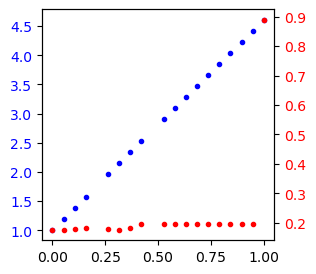

In [63]:
plt.figure(figsize=(3,3))
ax=plt.subplot(111)
ax.plot(list(best_cost.keys()),likelihood,'.', color="blue")
ax.tick_params(axis='y', labelcolor="blue")
ax1 = ax.twinx()
ax1.plot(list(best_cost.keys()),signal_error,'.', color="red")
ax1.tick_params(axis='y', labelcolor="red")



In [25]:
loo = history["losses"]
ll = np.array([[loo[k][0], loo[k][-1]] for k in range(len(loo))])

In [27]:
best_ind

377

Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

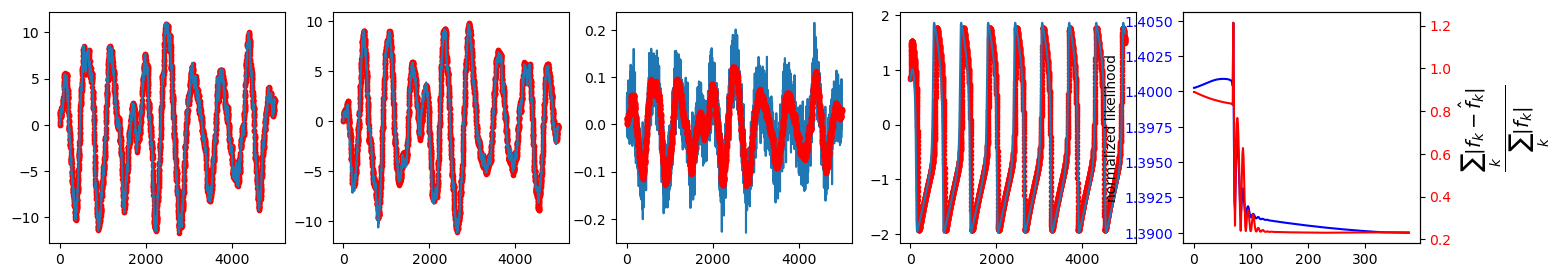

In [26]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])

ax=plt.subplot(175)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)


1
err


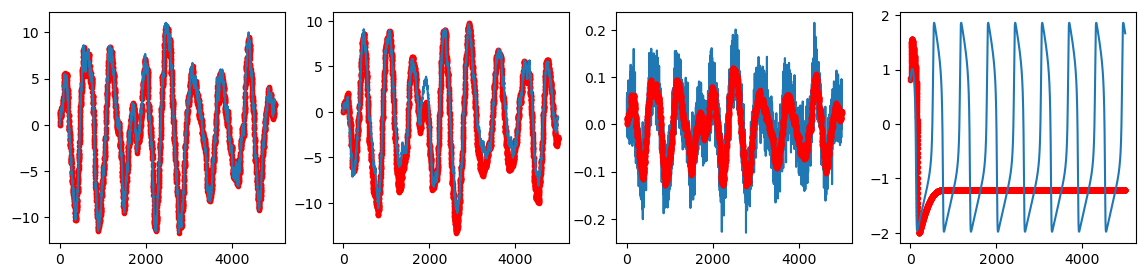

In [9]:
for itraj in range(1,2):
    print(itraj)
    try:
        mode="FHN"
        x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
        dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
        f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
        ####
        params, exp_path = give_params(mode=mode)
        gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
        period = (2*np.pi/omega)
        total_time = period*periods
        dt = period/ppp
        times = np.arange(0,total_time+dt,dt)
        ###

        torch.manual_seed(0)
        np.random.seed(0)


        a,b,I,tau, delay, zoom = np.array(params_force[1]) + np.random.randn((len(params_force[1])))*np.min(np.abs(params_force[1]))
        dev = torch.device("cpu")
        K0 = [I, a/tau]

        K1 = np.array([[1,-1],[1/tau,-b/tau]])

        K3 = np.array([[-1/3,0],[0,0]])

        inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [params_force[0], K0, K1, K3  ]]
        dev = torch.device("cpu")
        rrn = RecurrentNetwork(inputs_cell)

        optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

        dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
        ixs_hat, idys_hat, ifs_hats = rrn(dys)

        save_dir = "results/FHN/regularizers/"
        os.makedirs(save_dir,exist_ok=True)

        plt.figure(figsize=(25,3))
        ax=plt.subplot(171)
        ax.plot(ixs_hat.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(x[:,0])
        ax=plt.subplot(172)
        ax.plot(ixs_hat.detach().numpy()[:,1], color="red",marker='.')
        ax.plot(x[:,1])
        ax=plt.subplot(173)
        ax.plot(dys[:,0])
        ax.plot(idys_hat.detach().numpy()[:,0], color="red",marker='.')

        ax=plt.subplot(174)
        ax.plot(ifs_hats.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(f[:,0])
        plt.savefig(save_dir+"untrained_{}.png".format(itraj))

        history = load_history(what="FHN/regularizers/{}".format(alphas[itraj]), exp_path=exp_path,itraj=itraj)
        best_ind = set_params_to_best(rrn,history)
        xs_hat, dys_hat, fs_hats = rrn(dys)

        ll = np.stack(history["losses"])
        plt.figure(figsize=(25,3))
        ax=plt.subplot(171)
        ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(x[:,0])
        ax=plt.subplot(172)
        ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
        ax.plot(x[:,1])
        ax=plt.subplot(173)
        ax.plot(dys[:,0])
        ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

        ax=plt.subplot(174)
        ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(f[:,0])

        ax=plt.subplot(175)
        ax.plot(ll[:,0], color="blue")
        ax.set_ylabel("normalized likelihood")
        ax.tick_params(axis='y', labelcolor="blue")
        ax = ax.twinx()
        ax.plot(ll[:,1], color="red")
        ax.tick_params(axis='y', labelcolor="red")
        ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)
        plt.savefig(save_dir+"trained_{}.png".format(itraj))
    except Exception:
        print("err")
        pass

In [25]:
mode="FHN"
x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
####
params, exp_path = give_params(mode=mode)
gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)
###

torch.manual_seed(0)
np.random.seed(0)


a,b,I,tau, delay, zoom = np.array(params_force[1]) + np.random.randn((len(params_force[1])))*np.min(np.abs(params_force[1]))
dev = torch.device("cpu")
K0 = [I, a/tau]

K1 = np.array([[1,-1],[1/tau,-b/tau]])

K3 = np.array([[-1/3,0],[0,0]])

inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [params_force[0], K0, K1, K3  ]]
dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
ixs_hat, idys_hat, ifs_hats = rrn(dys)

save_dir = "results/FHN/regularizers/"
os.makedirs(save_dir,exist_ok=True)


In [28]:
list(rrn.parameters())[0]

Parameter containing:
tensor([0.8000, 1.0000], requires_grad=True)

In [24]:
itraj = 1
alphas = list(np.linspace(0., 1., 20))
load_history(what="FHN/regularizers/{}".format(alphas[0]), exp_path=exp_path,itraj=itraj)

{'losses': [[3.573934555053711, 0.8891201941784572],
  [3.573934555053711,
   array([1.0228121, 2.5511224], dtype=float32),
   0.8891201941784572],
  [3.6106393337249756,
   array([1.0216227, 2.5890167], dtype=float32),
   1.0314900302660723],
  [3.6031172275543213,
   array([1.0167596, 2.5863576], dtype=float32),
   0.7567989591461626],
  [nan, array([      nan, 2.5741787], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan], dtype=float32), nan],
  [nan, array([nan, nan]

UnpicklingError: invalid load key, '\x00'.

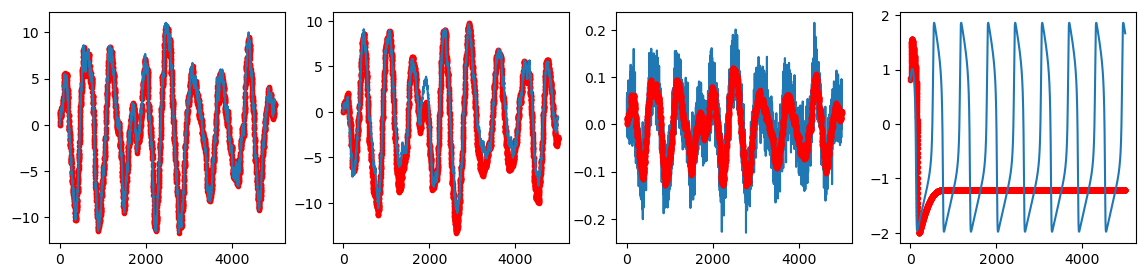

In [11]:

plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(ixs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(ixs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(idys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(ifs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])
plt.savefig(save_dir+"untrained_{}.png".format(itraj))
history = load_history(what="FHN/regularizers/{}".format(alphas[itraj]), exp_path=exp_path,itraj=itraj)

best_ind = set_params_to_best(rrn,history)
xs_hat, dys_hat, fs_hats = rrn(dys)

ll = np.stack(history["losses"])
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])

ax=plt.subplot(175)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)
plt.savefig(save_dir+"trained_{}.png".format(itraj))

/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)


In [26]:
list(rrn.parameters())

[Parameter containing:
 tensor([199.4303,   4.4193], requires_grad=True),
 Parameter containing:
 tensor([10.5311, -1.0628], requires_grad=True),
 Parameter containing:
 tensor([[-2.0018,  0.5142],
         [-1.4365, -0.4537]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0081, -0.1266],
         [ 0.0032, -0.0424]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0015,  0.0815],
         [-0.0086,  0.0514]], requires_grad=True)]

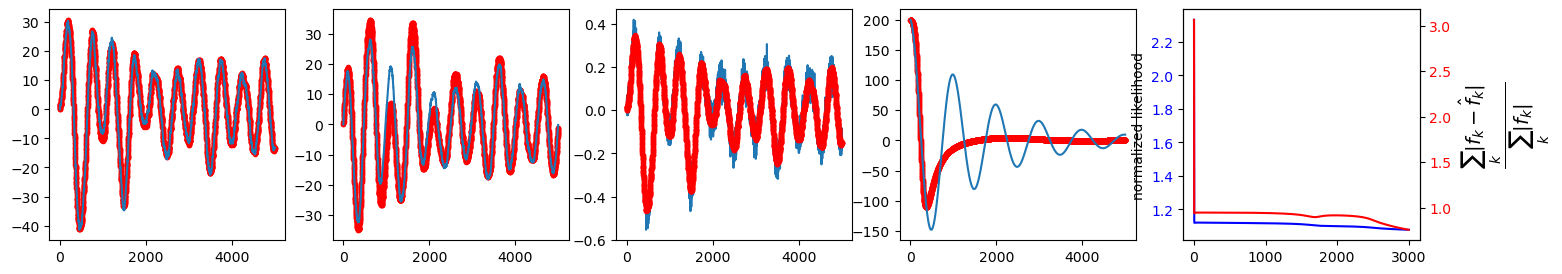

In [23]:
history["optimizer"]

KeyError: 'optimizer'

In [21]:
Ahist = np.squeeze(np.stack([history["params"][k][1] for k in range(len(history["params"]))]))
f0 = np.squeeze(np.stack([history["params"][k][0] for k in range(len(history["params"]))]))
b=params_force
true_gamma = b[1][0]
true_omega = b[1][1]
true_f0 = b[0][0]
true_f0_dot = b[0][1]
Atrue = np.array([[true_gamma, true_omega],[-true_omega, true_gamma]] )


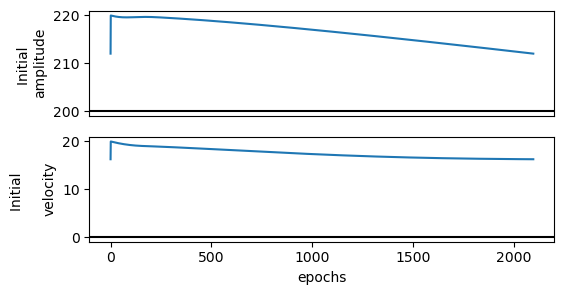

In [36]:
fig=plt.figure(figsize=(6,3))
ax=plt.subplot(211)
ax.plot(f0[:,0])
ax.set_ylabel("Initial \namplitude")
ax.set_xticks([])
ax.axhline(true_f0,color="black")
ax=plt.subplot(212)
ax.plot(f0[:,1])
ax.set_ylabel("Initial \n \nvelocity")
ax.axhline(true_f0_dot,color="black")
ax.set_xlabel("epochs")
plt.savefig(save_dir+"evolution_f0.pdf")

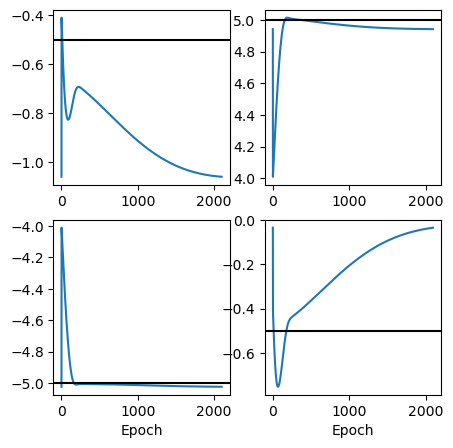

In [35]:
plt.figure(figsize=(5,5))
plt.tight_layout()
posis=[221,222,223,224]
k=0
for i in range(2):
    for j in range(2):
        ax=plt.subplot(posis[k])
        ax.plot(Ahist[:,i,j], label="pred")
        ax.axhline(Atrue[i,j],color="black")
        if k in [0,1]:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Epoch")            
        k+=1
plt.savefig(save_dir+"evolution_params.pdf")

In [30]:
history["losses"][best_ind]

[1.0093046426773071, 0.0775080375363841]

In [25]:
Ahist[best_ind]

array([[-1.0594219 ,  4.941394  ],
       [-5.024772  , -0.03439875]], dtype=float32)

In [26]:
Atrue

array([[-0.5,  5. ],
       [-5. , -0.5]])

In [27]:
f0[best_ind]

array([212.00351 ,  16.273136], dtype=float32)

In [29]:
[true_f0,true_f0_dot]

[200.0, 0.0]

In [23]:
best_params = []
for itraj in tqdm(range(1000)):
    try:
        history = load_history(what="exp_dec_2_params", exp_path=exp_path,itraj=itraj)
        index_favorite = np.argmin(np.array(history["losses"])[:,0])
        news = history["params"][index_favorite]
        best_params.append(news)
    except Exception:
        pass


100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]


In [24]:
len(best_params)

491

In [37]:
gf = 1.0
af = 200

fisher_AF = (4*eta*kappa/gamma)*(1-np.exp(-gf*times[-1]))**2

In [40]:
np.mean(np.array([best_params[k][0] for k in range(len(best_params))])- af)**2

360.91462449416576

In [44]:
np.std(np.array([best_params[k][0] for k in range(len(best_params))]))**2

124.25038576962925

In [41]:
1/fisher_AF

0.00376404515100404

In [43]:
kappa/gamma

66.66666666666667

In [171]:
torch.manual_seed(0)

dev = torch.device("cpu")

gf = .1
wf=.7
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [[200.,0], [[-gf,wf],[-wf,-gf]]  ]]

rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

xs_hat, dys_hat, fs_hats = rrn(dys)
loss = log_lik(dys, dys_hat)
history = {}
history["losses"] = [ [loss.item(),err_f(f[:,0],fs_hats[:,0])]  ]
history["params"] = [[k.detach().data for k in list(rrn.parameters())]]
history["gradients"] = []

In [167]:
printing=True

In [173]:
ll = np.stack(history["losses"])

In [198]:
torch.manual_seed(0)
gf = .1
wf=.7
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [[200.,0], [[-gf,wf],[-wf,-gf]]  ]]
irrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
ixs_hat, idys_hat, ifs_hats = irrn(dys)


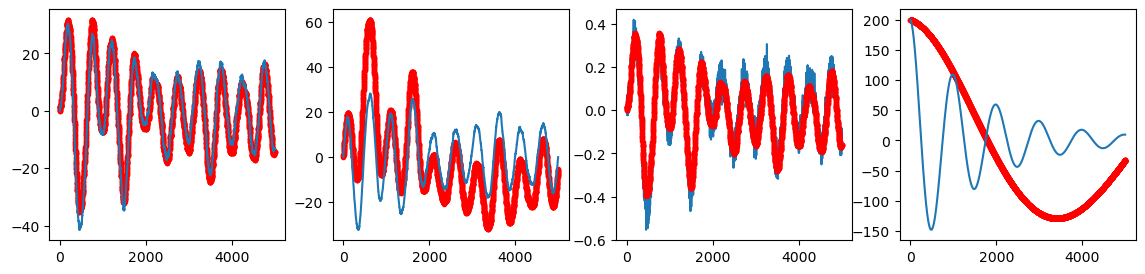

In [199]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(ixs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(ixs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(idys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(ifs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])


Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

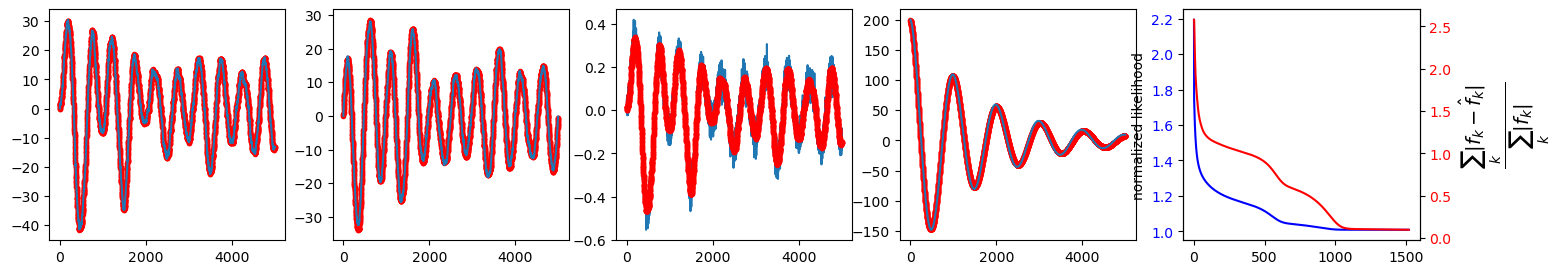

In [175]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])

ax=plt.subplot(175)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

In [188]:
Ahist = np.squeeze(np.stack([history["params"][k][1] for k in range(len(history["params"]))]))
f0 = np.squeeze(np.stack([history["params"][k][0] for k in range(len(history["params"]))]))
true_gamma = b[1][0]
true_omega = b[1][1]
true_f0 = b[0][0]
true_f0_dot = b[0][1]

In [195]:
Ahist[-1]

array([[-0.90564907,  4.9382286 ],
       [-4.9314656 , -0.12887985]], dtype=float32)

In [206]:
Ahist = np.squeeze(np.stack([history["params"][k][1] for k in range(len(history["params"]))]))
f0 = np.squeeze(np.stack([history["params"][k][0] for k in range(len(history["params"]))]))
true_gamma = b[1][0]
true_omega = b[1][1]
true_f0 = b[0][0]
true_f0_dot = b[0][1]
Atrue = np.array([[true_gamma, true_omega],[-true_omega, true_gamma]] )


In [202]:
Atrue

[[-0.5, 5.0], [-5.0, -0.5]]

Text(0.5, 0, 'epochs')

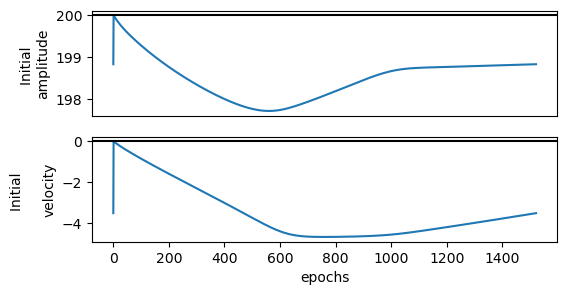

In [220]:
fig=plt.figure(figsize=(6,3))
ax=plt.subplot(211)
ax.plot(f0[:,0])
ax.set_ylabel("Initial \namplitude")
ax.set_xticks([])
ax.axhline(true_f0,color="black")
ax=plt.subplot(212)
ax.plot(f0[:,1])
ax.set_ylabel("Initial \n \nvelocity")
ax.axhline(true_f0_dot,color="black")
ax.set_xlabel("epochs")

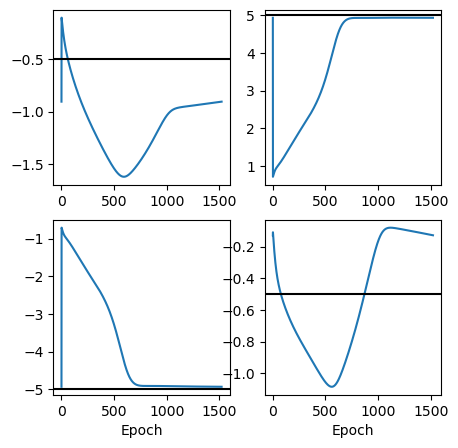

In [214]:
plt.figure(figsize=(5,5))
plt.tight_layout()
posis=[221,222,223,224]
k=0
for i in range(2):
    for j in range(2):
        ax=plt.subplot(posis[k])
        ax.plot(Ahist[:,i,j], label="pred")
        ax.axhline(Atrue[i,j],color="black")
        if k in [0,1]:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Epoch")            
        k+=1


In [182]:
np.squeeze(Ahist).shape

(1522, 2, 2)

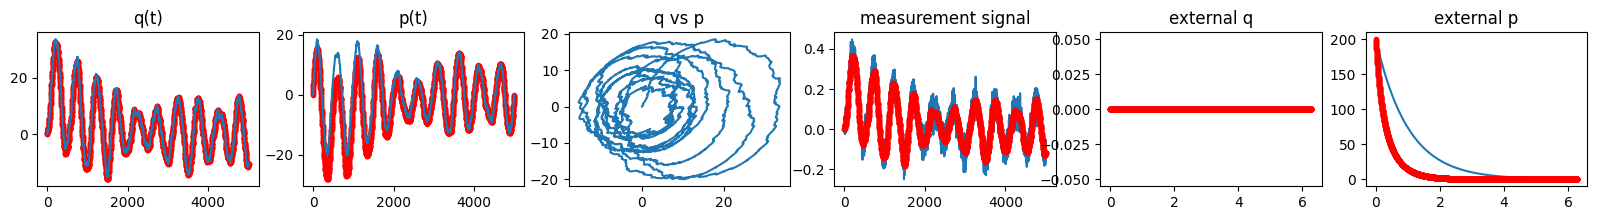


# Training

In [14]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(dt*len(dys))

def err_f(f,fhat):
    return np.sum(np.abs(f - fhat[:-1,:].detach().numpy() ))/np.sum(np.abs(f))

In [21]:
ll = np.stack(history["losses"])

Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

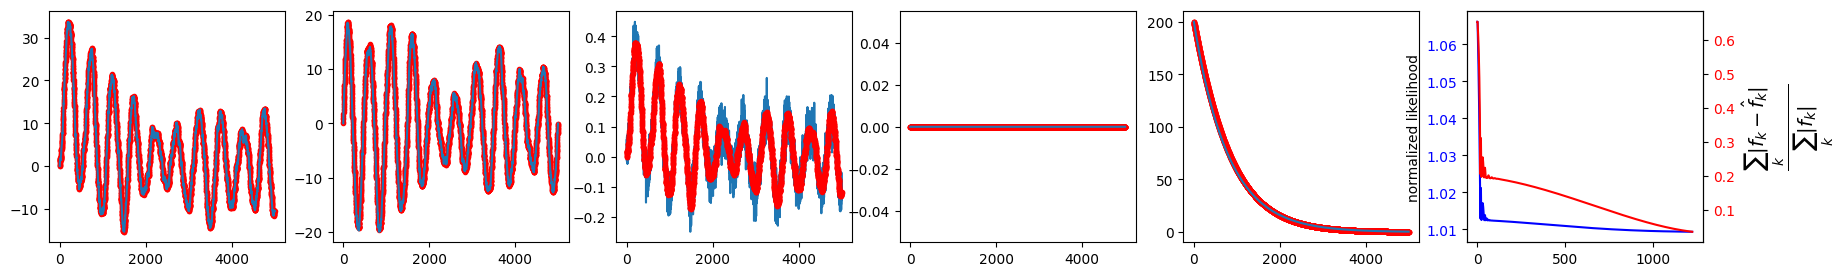

In [37]:
history["params"][4]

[array(1.6777, dtype=float32),
 array(-0.00103082, dtype=float32),
 array([0.64584786, 0.9788142 ], dtype=float32)]

In [38]:
[history["params"][k][0] for k in range(3,len(history["params"])-1)]

[array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1

In [22]:
import pickle
itraj = 1
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/DERIVATIVE_only_gamma/"
os.makedirs(path,exist_ok=True)

with open(path+"history.pickle", "wb") as output_file:
   pickle.dump(history, output_file)

In [35]:
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/PROFILE_only_gamma/"
with open(path+"history.pickle", "rb") as output_file:
   aa = pickle.load(output_file)
hsitory_prof = aa

In [25]:
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/DERIVATIVE_only_gamma/"

os.makedirs(path,exist_ok=True)

with open(path+"history.pickle", "wb") as output_file:
   pickle.dump(history, output_file)


with open(path+"history.pickle", "rb") as output_file:
   aa = pickle.load(output_file)

history_der = aa

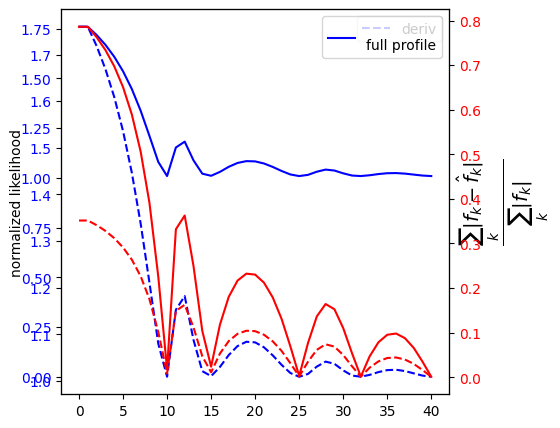

In [41]:
plt.figure(figsize=(5,5))
ax=plt.subplot()
ll = np.stack(history_der["losses"])
ax.plot(ll[:,0], '--',color="blue",label="deriv")
ax.legend()
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], '--', color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

ll = np.stack(hsitory_prof["losses"])
ax.plot(ll[:,0], color="blue",  label="\nfull profile")
ax.tick_params(axis='y', labelcolor="blue")

ax.legend()
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")


### Let's check now the amplitude!

In [125]:
xs_hat.shape

torch.Size([5002, 6])

In [131]:
[history["params"][k] for k in range(3,len(params))]

[[array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)]]

In [122]:
ll={}
for j in range(len(history["params"][0])):
    l[j] = [history["params"][k][j] for k in len(history["params"])]

TypeError: len() of unsized object

In [118]:
history["params"]

[array(nan, dtype=float32),
 array(nan, dtype=float32),
 array([nan, nan], dtype=float32),
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float3